# Task: Building an artificial neural network (LSTM) to predict yahoo stock prices using the past 60 day stock prices

<b>Objectives:<b>
    
1) To determine which hyperparameter technique between Random Search and Hyperband improves model performance better on our Yahoo stock price prediction.


<b> Hypotheses <b>

H0: Random Search provides better hyperparameter optimization than Hyperband.    


<b> Findings<b>
 1) Random search optimization algorithm is better at optimizing hyper-parameters to tune RNNs for optimal Yahoo stock price prediction

# Import Libraries

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout 
import dataframe_image as dfi
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [79]:
# Importing the data set into pandas
data = pd.read_csv("yahoo_stock.csv", sep = ";")

In [80]:
df = data.head()
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [81]:
# Saving the data frame ito a png format
dfi.export(df, 'dataframe.png')

In [82]:
# Looking at the shape of the data frame
data.shape

(1825, 7)

In [83]:
# Converting data column to date formate
data['Date'] = data['Date'].astype('datetime64[ns]')

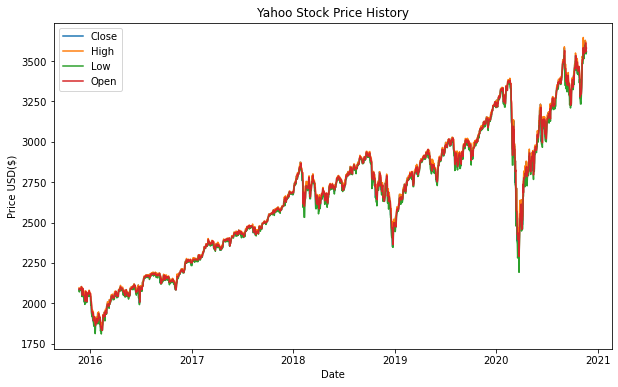

In [84]:
# Visualizing the data
plt.figure(figsize=(10,6))
plt.title("Yahoo Stock Price History")
plt.plot(data["Date"],data["Close"], label = "Close")
plt.plot(data["Date"], data["High"], label = "High")
plt.plot(data["Date"], data["Low"], label = "Low")
plt.plot(data["Date"], data["Open"], label = "Open")
plt.xlabel("Date")
plt.ylabel("Price USD($)")
plt.legend()
plt.savefig("Yahoo Stock Price.pdf", dpi=300, bbox_inches= "tight")
plt.show()

In [85]:
# Checking missing and NA values
data.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1825 non-null   datetime64[ns]
 1   High       1825 non-null   float64       
 2   Low        1825 non-null   float64       
 3   Open       1825 non-null   float64       
 4   Close      1825 non-null   float64       
 5   Volume     1825 non-null   float64       
 6   Adj Close  1825 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 99.9 KB


# LSTM Model Preparation

In [87]:
# Create a new dataframe with "Close" column 
df = data.filter(["Close"])

# Convert dataframe to numpy array
dataset = df.values
dataset

array([[2086.59008789],
       [2089.13989258],
       [2088.87011719],
       ...,
       [3567.79003906],
       [3581.87011719],
       [3557.54003906]])

In [88]:
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1460

In [89]:
# Scaling the data set
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.14323386],
       [0.14465213],
       [0.14450208],
       ...,
       [0.96711598],
       [0.97494769],
       [0.96141466]])

In [90]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i <= 60:
        print(x_train)
        print(y_train)

[array([0.14323386, 0.14465213, 0.14450208, 0.14450208, 0.14519179,
       0.14519179, 0.14519179, 0.13979629, 0.15215562, 0.13929574,
       0.1226702 , 0.14607054, 0.14607054, 0.14607054, 0.13793858,
       0.13044066, 0.12155768, 0.12412187, 0.10195071, 0.10195071,
       0.10195071, 0.10727376, 0.11921599, 0.13571368, 0.11837052,
       0.09815728, 0.09815728, 0.09815728, 0.10683439, 0.11674631,
       0.13082999, 0.12899442, 0.12899442, 0.12899442, 0.12899442,
       0.12649697, 0.13865613, 0.13031274, 0.11951074, 0.11951074,
       0.11951074, 0.11951074, 0.10211204, 0.10436471, 0.08965256,
       0.06341535, 0.05170126, 0.05170126, 0.05170126, 0.05261348,
       0.06096244, 0.03404108, 0.05159554, 0.02850659, 0.02850659,
       0.02850659, 0.02850659, 0.02906282, 0.01682584, 0.022199  ])]
[0.04328555550945978]


In [91]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [92]:
# Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1400, 60, 1)

# Building base-line LSTM Model

In [93]:
# Building the LSTM Model
model = Sequential()
model.add(LSTM(units = 50, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = "relu", return_sequences = False))
model.add(Dropout(0.5))

model.add(Dense(25))
model.add(Dense(1))

In [94]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 120)              

In [95]:
# Compile the model
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [96]:
# Training the model
model.fit(x_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
44/44 [==============================] - 7s 68ms/step - loss: 0.0331
Epoch 2/50
44/44 [==============================] - 3s 68ms/step - loss: 0.0062
Epoch 3/50
44/44 [==============================] - 3s 69ms/step - loss: 0.0043
Epoch 4/50
44/44 [==============================] - 3s 78ms/step - loss: 0.0040
Epoch 5/50
44/44 [==============================] - 3s 76ms/step - loss: 0.0040
Epoch 6/50
44/44 [==============================] - 3s 76ms/step - loss: 0.0032
Epoch 7/50
44/44 [==============================] - 3s 73ms/step - loss: 0.0031
Epoch 8/50
44/44 [==============================] - 3s 79ms/step - loss: 0.0035
Epoch 9/50
44/44 [==============================] - 4s 87ms/step - loss: 0.0031
Epoch 10/50
44/44 [==============================] - 4s 91ms/step - loss: 0.0038
Epoch 11/50
44/44 [==============================] - 4s 88ms/step - loss: 0.0027
Epoch 12/50
44/44 [==============================] - 3s 79ms/step - loss: 0.0026
Epoch 13/50
44/44 [==================

In [97]:
# Evaluating the base line model
model.evaluate(x_train,y_train)

44/44 [==============================] - 1s 19ms/step - loss: 8.1851e-04


0.000818513217382133

In [98]:
# Create the testing data set
# Create the training data set
# Create the scaled training data set
test_data = scaled_data[training_data_len-60:, :]
# Split the data into x_train and y_train data sets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [99]:
# Covert test data to numpy array
x_test = np.array(x_test)

In [100]:
# Reshaping the data
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [101]:
# Get predictions
Predictions_baseline = model.predict(x_test)
Predictions_baseline = scaler.inverse_transform(Predictions_baseline)
Predictions_baseline

array([[3050.8042],
       [3052.2656],
       [3053.0764],
       [3053.3994],
       [3053.8176],
       [3054.8157],
       [3056.7898],
       [3059.7676],
       [3063.2742],
       [3066.8281],
       [3070.0776],
       [3072.3242],
       [3072.8542],
       [3071.8608],
       [3069.8928],
       [3068.0042],
       [3066.879 ],
       [3066.7605],
       [3067.3965],
       [3068.3909],
       [3069.5989],
       [3071.4182],
       [3074.0286],
       [3077.3384],
       [3081.0906],
       [3085.396 ],
       [3090.2173],
       [3095.317 ],
       [3100.653 ],
       [3106.3748],
       [3112.4148],
       [3118.5337],
       [3124.485 ],
       [3130.0134],
       [3134.9185],
       [3139.3936],
       [3143.5613],
       [3147.433 ],
       [3150.9548],
       [3153.7021],
       [3155.636 ],
       [3156.855 ],
       [3158.0125],
       [3159.0918],
       [3159.9863],
       [3160.6272],
       [3161.2163],
       [3161.724 ],
       [3162.4036],
       [3163.7888],


In [102]:
# Evaluate the model with RMSE
rmse = np.sqrt(np.mean(Predictions_baseline - y_test)**2)
rmse

73.77907146297089

# Visualize the Predictions

<ipython-input-103-74bcf21619a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_baseline["Predictions_baseline"] = Predictions_baseline


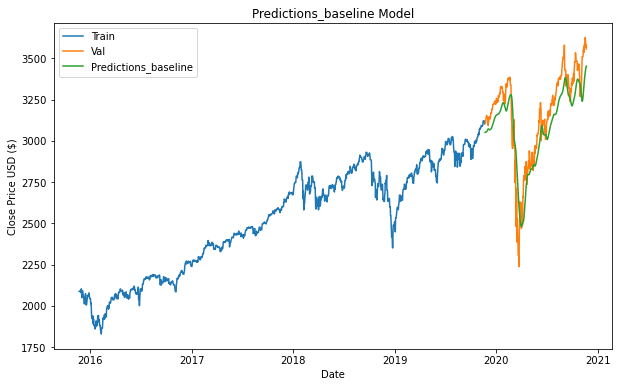

In [103]:
# Plot the data
train = data[:training_data_len]
valid_baseline = data[training_data_len:]
valid_baseline["Predictions_baseline"] = Predictions_baseline
plt.figure(figsize=(10,6))
plt.title("Predictions_baseline Model")
plt.xlabel("Date")
plt.ylabel("Close Price USD ($)")
plt.plot(train["Date"],train["Close"])
plt.plot(valid_baseline["Date"],valid_baseline["Close"])
plt.plot(valid_baseline["Date"],valid_baseline["Predictions_baseline"])
plt.legend(["Train", "Val", "Predictions_baseline"])
plt.savefig("Predictions_baseline.pdf", dpi=300, bbox_inches= "tight")
plt.show()

In [104]:
# Showing actual prices and predicted prices
valid = valid_baseline.drop(["High", "Low", "Open", "Volume", "Adj Close"], axis = 1)
valid

,Date,Close,Predictions_baseline
1460,2019-11-22,3110.290039,3050.804199
1461,2019-11-23,3110.290039,3052.265625
1462,2019-11-24,3110.290039,3053.076416
1463,2019-11-25,3133.639893,3053.399414
1464,2019-11-26,3140.520020,3053.817627
...,...,...,...
1820,2020-11-16,3626.909912,3414.825195
1821,2020-11-17,3609.530029,3427.020264
1822,2020-11-18,3567.790039,3438.059570
1823,2020-11-19,3581.870117,3446.915527


# Introducing Hyper-parameter Tuning

<b>Hyper-parameter tuning using Random Search<b>

In [105]:
import keras_tuner as tf
from tensorflow import keras
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [106]:
np.random.seed(42)

In [107]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int("num_of_layers", 2, 20)):
        model.add(layers.Dense(units = hp.Int("units",
                                 min_value = 32,
                                 max_value = 512,
                                 step = 16),
                        activation = "relu"))
    
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5))),
    model.add(layers.Dense(1, activation = "linear")),
    model.compile(
        optimizer = keras.optimizers.Adam(
            hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss = "mean_squared_error",
        metrics = ["mean_squared_error"])
    return model

In [108]:
tuner = tf.RandomSearch(
    build_model,
    objective="val_mean_squared_error",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="Machine Learning Project",
)

In [109]:
tuner.search(x_train, y_train,
             epochs=15, batch_size = 32,
             validation_data=(x_test, y_test))

Trial 10 Complete [00h 00m 23s]
val_mean_squared_error: 10062558.5

Best val_mean_squared_error So Far: 10062098.0
Total elapsed time: 00h 20m 50s
INFO:tensorflow:Oracle triggered exit


In [110]:
tuner.results_summary(1)

Results summary
Results in my_dir/Machine Learning Project
Showing 1 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_of_layers: 16
units: 464
dropout_rate: 0.13795724772664003
learning_rate: 0.001
Score: 10062098.0


In [111]:
# Building the LSTM Model
model = Sequential()
model.add(LSTM(units = 320, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.41))

model.add(LSTM(units = 320, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.41))

model.add(LSTM(units = 320, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.41))

model.add(LSTM(units = 320, activation = "relu", return_sequences = False))
model.add(Dropout(0.41))

model.add(Dense(25))
model.add(Dense(1))

In [112]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 320)           412160    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 320)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 320)           820480    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 320)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 320)           820480    
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 320)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 320)              

In [113]:
# Compile the model
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [114]:
# Object class to reduce learning rate
# tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_loss",
#     factor=0.1,
#     patience=10,
#     verbose=0,
#     mode="auto",
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=0,
# )
reduce_lr = ReduceLROnPlateau(monitor='lr', factor=0.2,
                              patience=5, min_lr=0.001)

In [115]:
# Training the model
model.fit(x_train, y_train, batch_size=32, epochs=50, callbacks=[reduce_lr])

Epoch 1/50
44/44 [==============================] - 31s 621ms/step - loss: 0.0677
Epoch 2/50
44/44 [==============================] - 27s 611ms/step - loss: 0.0043
Epoch 3/50
44/44 [==============================] - 35s 805ms/step - loss: 0.0027
Epoch 4/50
44/44 [==============================] - 28s 635ms/step - loss: 0.0028
Epoch 5/50
44/44 [==============================] - 34s 776ms/step - loss: 0.0021
Epoch 6/50
44/44 [==============================] - 35s 788ms/step - loss: 0.0021
Epoch 7/50
44/44 [==============================] - 32s 721ms/step - loss: 0.0021
Epoch 8/50
44/44 [==============================] - 32s 733ms/step - loss: 0.0019
Epoch 9/50
44/44 [==============================] - 33s 743ms/step - loss: 0.0017
Epoch 10/50
44/44 [==============================] - 32s 733ms/step - loss: 0.0017
Epoch 11/50
44/44 [==============================] - 32s 721ms/step - loss: 0.0017
Epoch 12/50
44/44 [==============================] - 36s 808ms/step - loss: 0.0016
Epoch 13/50
4

In [62]:
model.count_params()

2881651

In [63]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 2s 128ms/step - loss: 10062306.0000


10062306.0

In [64]:
model.evaluate(x_train,y_train)

44/44 [==============================] - 7s 136ms/step - loss: 3.8626e-04


0.000386260449886322

In [65]:
# Get predictions
predictions_random_search = model.predict(x_test)
predictions_random_search = scaler.inverse_transform(predictions_random_search)
predictions_random_search

array([[3131.0242],
       [3129.4092],
       [3127.4177],
       [3125.717 ],
       [3126.297 ],
       [3129.855 ],
       [3136.388 ],
       [3144.4556],
       [3151.3835],
       [3155.919 ],
       [3158.0671],
       [3156.6565],
       [3150.916 ],
       [3143.3477],
       [3136.495 ],
       [3133.7239],
       [3135.6187],
       [3140.6804],
       [3146.1545],
       [3150.1704],
       [3152.8552],
       [3156.5063],
       [3161.5237],
       [3167.102 ],
       [3172.2246],
       [3177.8943],
       [3184.0266],
       [3189.7656],
       [3195.4448],
       [3201.9722],
       [3208.9075],
       [3215.3145],
       [3220.7068],
       [3224.769 ],
       [3227.4717],
       [3230.1375],
       [3233.1921],
       [3236.4268],
       [3239.4468],
       [3240.697 ],
       [3240.5889],
       [3239.8044],
       [3240.7163],
       [3242.2905],
       [3243.63  ],
       [3244.3784],
       [3245.3406],
       [3246.1602],
       [3247.6965],
       [3251.5142],


In [66]:
# Evaluate the model with RMSE
rmse = np.sqrt(np.mean(predictions_random_search - y_test)**2)
rmse

2.3166651059503423

<ipython-input-67-260e601ae8d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_random_search["Predictions_random_search"] = predictions_random_search


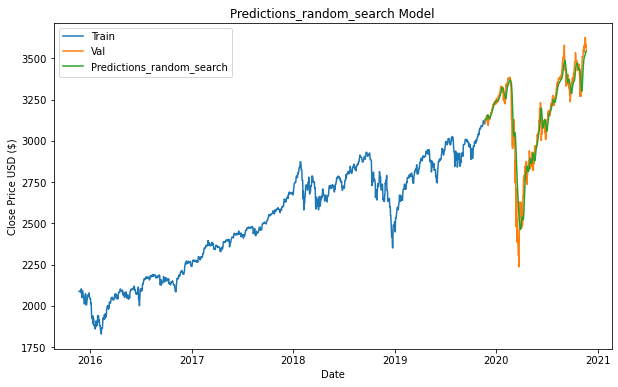

In [67]:
# Plot the data
train = data[:training_data_len]
valid_random_search = data[training_data_len:]
valid_random_search["Predictions_random_search"] = predictions_random_search
plt.figure(figsize=(10,6))
plt.title("Predictions_random_search Model")
plt.xlabel("Date")
plt.ylabel("Close Price USD ($)")
plt.plot(train["Date"],train["Close"])
plt.plot(valid_random_search["Date"],valid_random_search["Close"])
plt.plot(valid_random_search["Date"],valid_random_search["Predictions_random_search"])
plt.legend(["Train", "Val", "Predictions_random_search"])
plt.savefig("Predictions_random_search.pdf", dpi=300, bbox_inches= "tight")
plt.show()

In [68]:
# Showing actual prices and predicted prices
valid = valid_random_search.drop(["High", "Low", "Open", "Volume", "Adj Close"], axis = 1)
valid

,Date,Close,Predictions_random_search
1460,2019-11-22,3110.290039,3131.024170
1461,2019-11-23,3110.290039,3129.409180
1462,2019-11-24,3110.290039,3127.417725
1463,2019-11-25,3133.639893,3125.717041
1464,2019-11-26,3140.520020,3126.297119
...,...,...,...
1820,2020-11-16,3626.909912,3522.889893
1821,2020-11-17,3609.530029,3530.413574
1822,2020-11-18,3567.790039,3539.104492
1823,2020-11-19,3581.870117,3544.589844


<b>Hyper-parameter Tuning using Hyperband<b>

In [70]:
tuner = tf.Hyperband(build_model,
                     objective = 'val_mean_squared_error', 
                     max_epochs = 10,
                     overwrite=True,
                     factor = 3,
                     directory = 'my_directory',
                     project_name = 'Machine Learning Ass')

In [71]:
tuner.search(x_train, y_train,
             epochs=15, batch_size = 32,
             validation_data=(x_test, y_test))

Trial 30 Complete [00h 00m 04s]
val_mean_squared_error: 10063260.0

Best val_mean_squared_error So Far: 10062133.0
Total elapsed time: 00h 06m 32s
INFO:tensorflow:Oracle triggered exit


In [72]:
tuner.results_summary(1)

Results summary
Results in my_directory/Machine Learning Ass
Showing 1 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_of_layers: 4
units: 64
dropout_rate: 0.2755900403904218
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 91a62d3c5e7015b5a38ce9c9d5fd17cf
Score: 10062133.0


In [116]:
# Building the LSTM Model
model = Sequential()

model.add(LSTM(units = 416, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.19))

model.add(LSTM(units = 416, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.19))

model.add(LSTM(units = 416, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.19))

model.add(LSTM(units = 416, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.19))

model.add(LSTM(units = 416, activation = "relu", return_sequences = False))
model.add(Dropout(0.19))

model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.summary()

In [74]:
# Compile the model
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [75]:
# Object class to reduce learning rate
# tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_loss",
#     factor=0.1,
#     patience=10,
#     verbose=0,
#     mode="auto",
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=0,
# )
reduce_lr = ReduceLROnPlateau(monitor='lr', factor=0.2,
                              patience=5, min_lr=0.0001)

In [76]:
# Training the model
model.fit(x_train, y_train, batch_size=32, epochs=50, callbacks=[reduce_lr])

Epoch 1/50
44/44 [==============================] - 57s 1s/step - loss: 0.0578
Epoch 2/50
44/44 [==============================] - 55s 1s/step - loss: 0.0023
Epoch 3/50
44/44 [==============================] - 56s 1s/step - loss: 0.0020
Epoch 4/50
44/44 [==============================] - 53s 1s/step - loss: 0.0020
Epoch 5/50
44/44 [==============================] - 53s 1s/step - loss: 0.0016
Epoch 6/50
44/44 [==============================] - 57s 1s/step - loss: 0.0015
Epoch 7/50
44/44 [==============================] - 62s 1s/step - loss: 0.0013
Epoch 8/50
44/44 [==============================] - 60s 1s/step - loss: 0.0012
Epoch 9/50
44/44 [==============================] - 61s 1s/step - loss: 0.0013
Epoch 10/50
44/44 [==============================] - 64s 1s/step - loss: 0.0012
Epoch 11/50
44/44 [==============================] - 58s 1s/step - loss: 0.0012
Epoch 12/50
44/44 [==============================] - 61s 1s/step - loss: 0.0012
Epoch 13/50
44/44 [==============================

KeyboardInterrupt: 

In [114]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 4s 284ms/step - loss: 10062438.0000


10062438.0

In [115]:
model.evaluate(x_train,y_train)

44/44 [==============================] - 13s 281ms/step - loss: 5.3556e-04


0.0005355581524781883

In [116]:
# Get predictions
predictions_hyperband = model.predict(x_test)
predictions_hyperband = scaler.inverse_transform(predictions_hyperband)
predictions_hyperband

array([[3090.7583],
       [3093.2688],
       [3095.3005],
       [3096.772 ],
       [3097.7825],
       [3098.5786],
       [3099.5059],
       [3100.8894],
       [3102.884 ],
       [3105.466 ],
       [3108.477 ],
       [3111.559 ],
       [3114.1772],
       [3115.8906],
       [3116.4756],
       [3116.068 ],
       [3115.042 ],
       [3113.8499],
       [3112.8486],
       [3112.235 ],
       [3112.0996],
       [3112.5754],
       [3113.7996],
       [3115.8474],
       [3118.6965],
       [3122.3264],
       [3126.6946],
       [3131.6948],
       [3137.2048],
       [3143.162 ],
       [3149.5042],
       [3156.1267],
       [3162.8787],
       [3169.568 ],
       [3175.9805],
       [3181.984 ],
       [3187.517 ],
       [3192.557 ],
       [3197.0935],
       [3201.0286],
       [3204.2642],
       [3206.7407],
       [3208.5806],
       [3209.9133],
       [3210.8438],
       [3211.4434],
       [3211.8162],
       [3212.0393],
       [3212.2349],
       [3212.6392],


In [117]:
# Evaluate the model with RMSE
rmse = np.sqrt(np.mean(predictions_hyperband - y_test)**2)
rmse

33.5441352739726

<ipython-input-119-22929b635e9d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_hyperband["Predictions_hyperband"] = predictions_hyperband


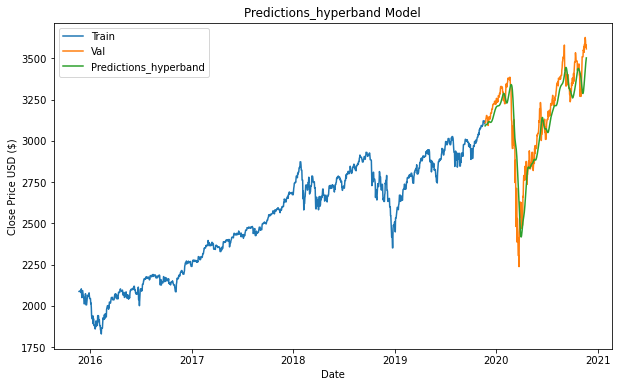

In [119]:
# Plot the data
train = data[:training_data_len]
valid_hyperband = data[training_data_len:]
valid_hyperband["Predictions_hyperband"] = predictions_hyperband
plt.figure(figsize=(10,6))
plt.title("Predictions_hyperband Model")
plt.xlabel("Date")
plt.ylabel("Close Price USD ($)")
plt.plot(train["Date"],train["Close"])
plt.plot(valid_hyperband["Date"],valid_hyperband["Close"])
plt.plot(valid_hyperband["Date"],valid_hyperband["Predictions_hyperband"])
plt.legend(["Train", "Val", "Predictions_hyperband"])
plt.savefig("Predictions_hyperband.pdf", dpi=300, bbox_inches= "tight")
plt.show()

In [120]:
# Showing actual prices and predicted prices
valid = valid_hyperband.drop(["High", "Low", "Open", "Volume", "Adj Close"], axis = 1)
valid

,Date,Close,Predictions_hyperband
1460,2019-11-22,3110.290039,3090.758301
1461,2019-11-23,3110.290039,3093.268799
1462,2019-11-24,3110.290039,3095.300537
1463,2019-11-25,3133.639893,3096.771973
1464,2019-11-26,3140.520020,3097.782471
...,...,...,...
1820,2020-11-16,3626.909912,3433.449951
1821,2020-11-17,3609.530029,3454.080078
1822,2020-11-18,3567.790039,3472.776367
1823,2020-11-19,3581.870117,3489.175537


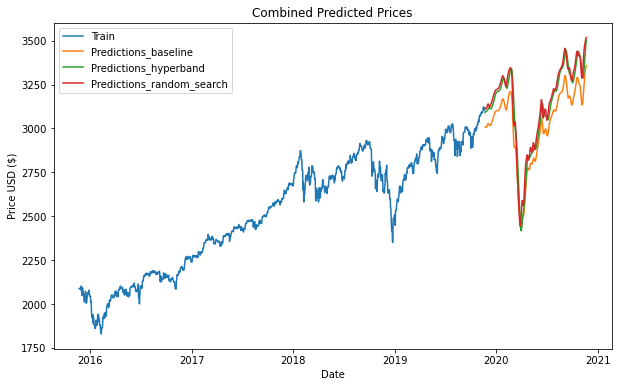

In [121]:
# Plot all the models
plt.figure(figsize=(10,6))
plt.title("Combined Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price USD ($)")
plt.plot(train["Date"],train["Close"])
plt.plot(valid_baseline["Date"],valid_baseline["Predictions_baseline"])
plt.plot(valid_hyperband["Date"],valid_hyperband["Predictions_hyperband"])
plt.plot(valid_random_search["Date"],valid_random_search["Predictions_random_search"])
plt.legend(["Train", "Predictions_baseline", "Predictions_hyperband", "Predictions_random_search"])
plt.savefig("Combined Predicted Prices.pdf", dpi=300, bbox_inches= "tight")
plt.show()

In [122]:
valid["Predictions_baseline"]= valid_baseline["Predictions_baseline"]
valid["Predictions_hyperband"]= valid_hyperband["Predictions_hyperband"]
valid["Predictions_random_search"]= valid_random_search["Predictions_random_search"]

In [123]:
valid

,Date,Close,Predictions_hyperband,Predictions_baseline,Predictions_random_search
1460,2019-11-22,3110.290039,3090.758301,3008.119629,3115.497070
1461,2019-11-23,3110.290039,3093.268799,3009.113770,3115.345459
1462,2019-11-24,3110.290039,3095.300537,3009.263428,3114.341797
1463,2019-11-25,3133.639893,3096.771973,3008.795654,3113.083252
1464,2019-11-26,3140.520020,3097.782471,3008.447754,3112.870361
...,...,...,...,...,...
1820,2020-11-16,3626.909912,3433.449951,3326.620605,3493.082520
1821,2020-11-17,3609.530029,3454.080078,3338.180908,3501.138184
1822,2020-11-18,3567.790039,3472.776367,3347.883057,3509.259033
1823,2020-11-19,3581.870117,3489.175537,3354.663086,3515.234619


In [600]:
tuner = kt.BayesianOptimization(
    build_model,
    objective= "mean_squared_error",
    max_trials= 5,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=None,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True,
    directory = 'my_directory',
    project_name = 'Machine Learning Ass')

In [601]:
tuner.search(x_train, y_train,
             epochs=15, batch_size = 32,
             validation_data=(x_test, y_test))

Trial 5 Complete [00h 00m 26s]
mean_squared_error: 0.003357791807502508

Best mean_squared_error So Far: 0.002181580290198326
Total elapsed time: 00h 07m 00s
INFO:tensorflow:Oracle triggered exit


In [602]:
tuner.results_summary(1)

Results summary
Results in my_directory/Machine Learning Ass
Showing 1 best trials
Objective(name='mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_of_layers: 2
units: 512
dropout_rate: 0.1
learning_rate: 0.0001
Score: 0.002181580290198326


In [603]:
# Building the LSTM Model
model = Sequential()

model.add(LSTM(units = 512, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.1))

model.add(LSTM(units = 512, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.1))

model.add(LSTM(units = 512, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.1))

model.add(LSTM(units = 352, activation = "relu", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.1))

model.add(LSTM(units = 512, activation = "relu", return_sequences = False))
model.add(Dropout(0.1))

model.add(Dense(25))
model.add(Dense(1))

In [604]:
# Compile the model
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [605]:
# Object class to reduce learning rate
tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
reduce_lr = ReduceLROnPlateau(monitor='lr', factor=0.2,
                              patience=5, min_lr=0.0001)

In [606]:
# Training the model
model.fit(x_train, y_train, batch_size=32, epochs=50, callbacks=[reduce_lr])

Epoch 1/50
44/44 [==============================] - 77s 2s/step - loss: 0.1044
Epoch 2/50
44/44 [==============================] - 130s 3s/step - loss: 0.0023
Epoch 3/50
44/44 [==============================] - 167s 4s/step - loss: 0.0016
Epoch 4/50
44/44 [==============================] - 110s 2s/step - loss: 0.0016
Epoch 5/50
44/44 [==============================] - 87s 2s/step - loss: 0.0014
Epoch 6/50
44/44 [==============================] - 83s 2s/step - loss: 0.0020
Epoch 7/50
44/44 [==============================] - 89s 2s/step - loss: 0.0012
Epoch 8/50
44/44 [==============================] - 86s 2s/step - loss: 0.0012
Epoch 9/50
44/44 [==============================] - 82s 2s/step - loss: 0.0012
Epoch 10/50
44/44 [==============================] - 92s 2s/step - loss: 0.0011
Epoch 11/50
44/44 [==============================] - 84s 2s/step - loss: 0.0011
Epoch 12/50
44/44 [==============================] - 74s 2s/step - loss: 0.0011
Epoch 13/50
44/44 [===========================

In [607]:
# Get predictions
predictions_bayes_opt = model.predict(x_test)
predictions_bayes_opt = scaler.inverse_transform(predictions_bayes_opt)
predictions_bayes_opt

array([[3070.23  ],
       [3072.7795],
       [3075.0007],
       [3076.7937],
       [3078.186 ],
       [3079.3228],
       [3080.4492],
       [3081.829 ],
       [3083.631 ],
       [3085.9058],
       [3088.596 ],
       [3091.4702],
       [3094.1309],
       [3096.1997],
       [3097.418 ],
       [3097.7761],
       [3097.4622],
       [3096.7683],
       [3095.9766],
       [3095.2954],
       [3094.8792],
       [3094.914 ],
       [3095.5803],
       [3097.001 ],
       [3099.2148],
       [3102.2446],
       [3106.079 ],
       [3110.6436],
       [3115.8425],
       [3121.5933],
       [3127.8074],
       [3134.369 ],
       [3141.1355],
       [3147.939 ],
       [3154.5916],
       [3160.957 ],
       [3166.9453],
       [3172.4985],
       [3177.5757],
       [3182.084 ],
       [3185.9324],
       [3189.0613],
       [3191.5352],
       [3193.4353],
       [3194.8384],
       [3195.8086],
       [3196.4456],
       [3196.835 ],
       [3197.0974],
       [3197.4365],


In [608]:
# Evaluate the model with RMSE
rmse = np.sqrt(np.mean(predictions_bayes_opt - y_test)**2)
rmse

50.66376752461473

<ipython-input-609-2a8b28a7692a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_bayes_opt["predictions_bayes_opt"] = predictions_bayes_opt


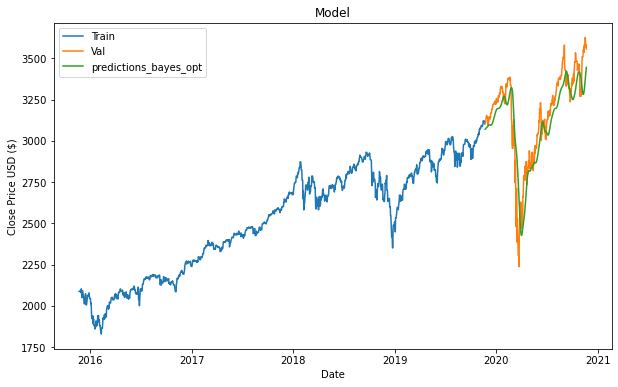

In [609]:
# Plot the data
train = data[:training_data_len]
valid_bayes_opt = data[training_data_len:]
valid_bayes_opt["predictions_bayes_opt"] = predictions_bayes_opt 
plt.figure(figsize=(10,6))
plt.title("Model")
plt.xlabel("Date")
plt.ylabel("Close Price USD ($)")
plt.plot(train["Date"],train["Close"])
plt.plot(valid_bayes_opt["Date"],valid_bayes_opt["Close"])
plt.plot(valid_bayes_opt["Date"],valid_bayes_opt["predictions_bayes_opt"])
plt.legend(["Train", "Val", "predictions_bayes_opt"])
plt.show()

In [610]:
valid_bayes_opt

,Date,High,Low,Open,Close,Volume,Adj Close,predictions_bayes_opt
1460,2019-11-22,3112.870117,3099.260010,3111.409912,3110.290039,3.226780e+09,3110.290039,3070.229980
1461,2019-11-23,3112.870117,3099.260010,3111.409912,3110.290039,3.226780e+09,3110.290039,3072.779541
1462,2019-11-24,3112.870117,3099.260010,3111.409912,3110.290039,3.226780e+09,3110.290039,3075.000732
1463,2019-11-25,3133.830078,3117.439941,3117.439941,3133.639893,3.511530e+09,3133.639893,3076.793701
1464,2019-11-26,3142.689941,3131.000000,3134.850098,3140.520020,4.595590e+09,3140.520020,3078.186035
...,...,...,...,...,...,...,...,...
1820,2020-11-16,3628.510010,3600.159912,3600.159912,3626.909912,5.281980e+09,3626.909912,3369.811768
1821,2020-11-17,3623.110107,3588.679932,3610.310059,3609.530029,4.799570e+09,3609.530029,3389.351807
1822,2020-11-18,3619.090088,3567.330078,3612.090088,3567.790039,5.274450e+09,3567.790039,3408.824463
1823,2020-11-19,3585.219971,3543.840088,3559.409912,3581.870117,4.347200e+09,3581.870117,3427.673340
